## C√°lculo para Ciencias de datos : Tarea 1 üåé

Para el desarrollo de esta tarea se utilizan expl√≠citamente a lo largo del notebook casi todos los c√≥digo de ejemplo entregados en canvas para poder realizar el an√°lisis de las distancias, los plots y la b√∫squeda de los vecinos m√°s cercanos. 

Nota de ejecucci√≥n : Para leer los archivos correctamente, estos deben encontrarse en el mismo directorio del notebook. 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import math 

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
print(df_empirical_Holocene) # Se imprimen los dataframes para conocer mejor los datos 
print(df_empirical_LGM)

        lon    lat       dep   log_dep  log_dep_norm
0      1.37  78.87  3.999995  0.602059      0.185196
1    -61.00  77.00  0.040000 -1.397941     -1.669137
2    -42.32  75.10  0.008000 -2.096911     -2.317199
3     -6.72  74.58  3.100001  0.491362      0.082561
4    -37.63  72.58  0.009000 -2.045758     -2.269772
..      ...    ...       ...       ...           ...
392    0.00 -75.00  0.002000 -2.698970     -2.875408
393  123.35 -75.10  0.000400 -3.397941     -3.523470
394  107.00 -78.00  0.000700 -3.154901     -3.298132
395  107.00 -78.00  0.000400 -3.397941     -3.523470
396 -120.00 -80.00  0.003000 -2.522879     -2.712142

[397 rows x 5 columns]
        lon    lat        dep   log_dep  log_dep_norm
0    -61.00  77.00   0.080000 -1.096911     -2.662962
1    -42.32  75.10   0.170000 -0.769551     -2.317613
2    -37.63  72.58   0.326000 -0.486782     -2.019304
3    129.42  71.77  81.999907  1.913813      0.513214
4    -27.00  71.00   0.120000 -0.920818     -2.477192
..      ...    .

In [4]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [5]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='magma',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


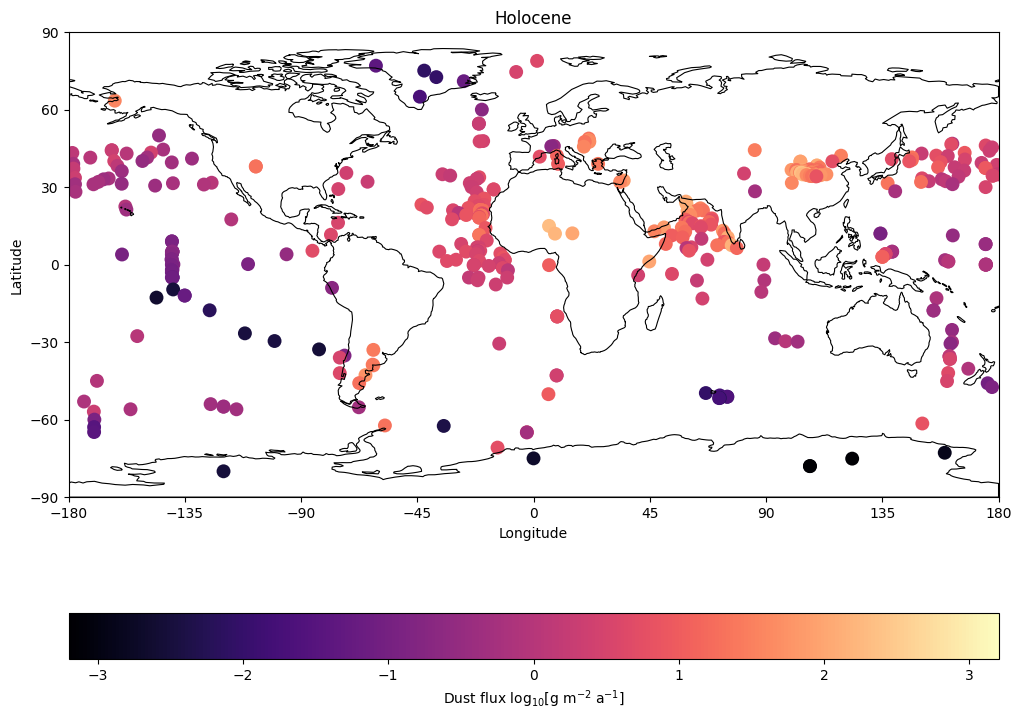

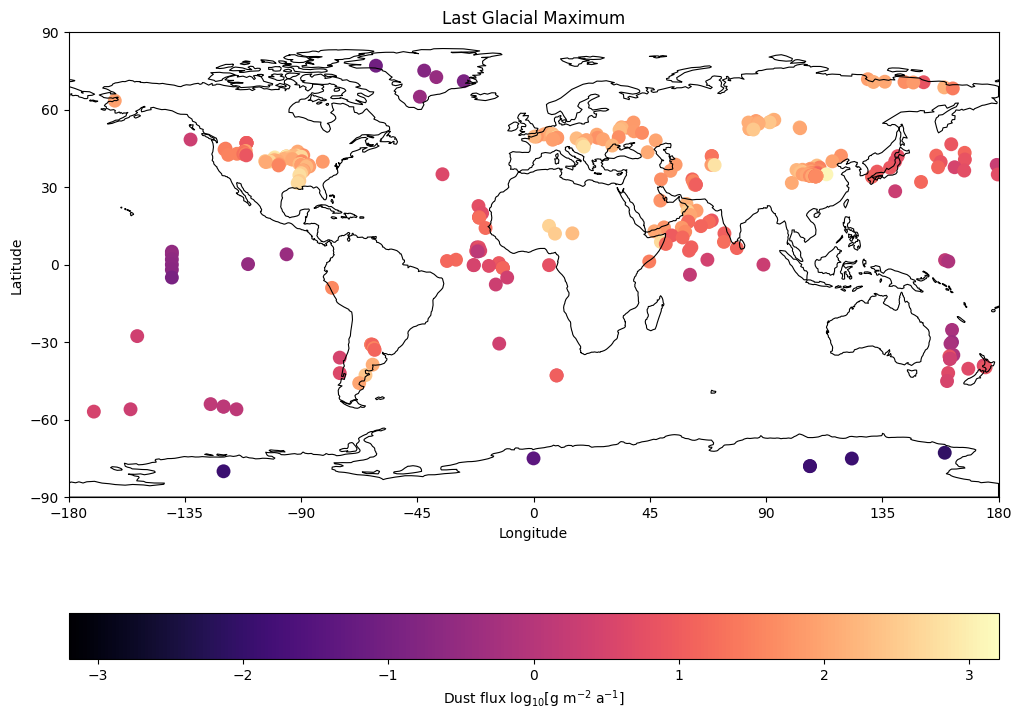

In [6]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [7]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

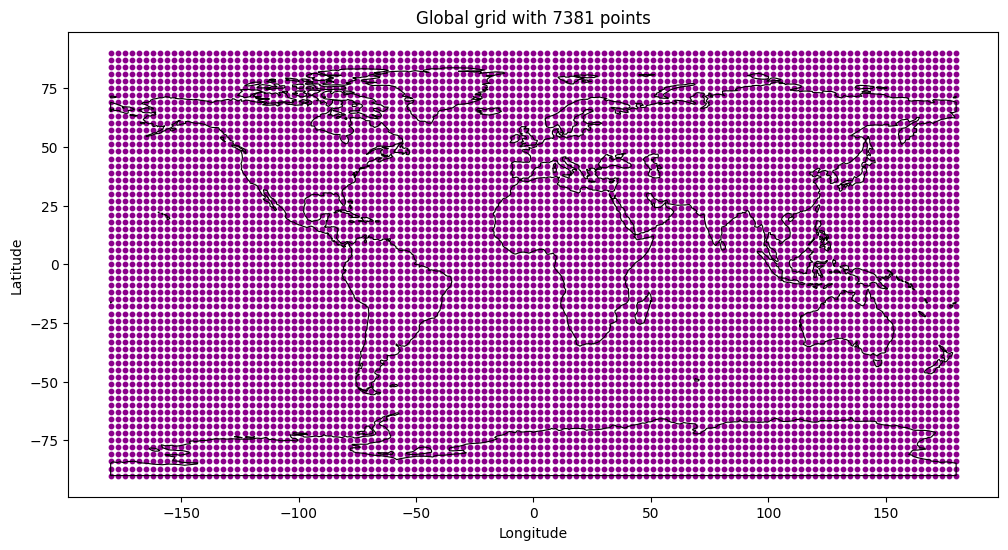

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='darkmagenta', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [9]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [10]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    earth_radius = 6371.0 #source = Chat gpt
    longitud_rad_x = math.radians(x[0])
    longitud_rad_y = math.radians(y[0])
    latitud_rad_x = math.radians(x[1])
    latitud_rad_y = math.radians(y[1])
    geodesic_distance = earth_radius * np.arccos(np.sin(latitud_rad_x) * np.sin(latitud_rad_y) + np.cos(latitud_rad_x) * np.cos(latitud_rad_y) * np.cos(longitud_rad_y - longitud_rad_x)) 
                                                                                                                  
    return geodesic_distance

In [11]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [12]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [13]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

In [14]:
#Se almacena una copia de los datos de estimaci√≥n con distancia euclidiana para que no se sobreescriban en el df
est_euclidian_hol = df_global_grid["est_hol"].copy() 
est_euclidian_lgm = df_global_grid["est_lgm"].copy()

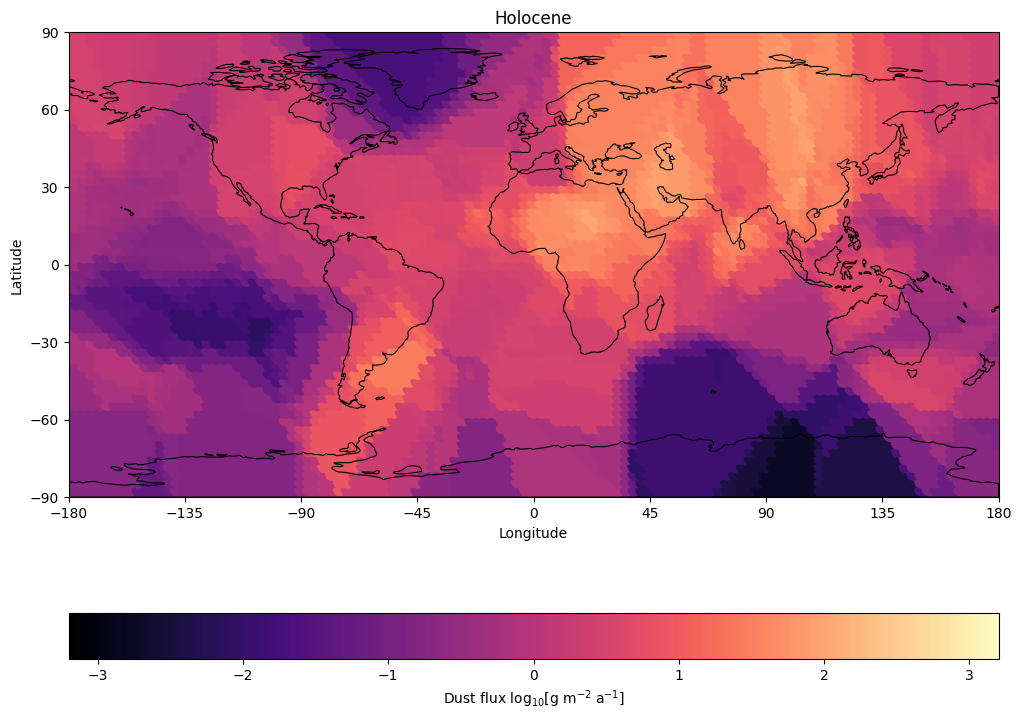

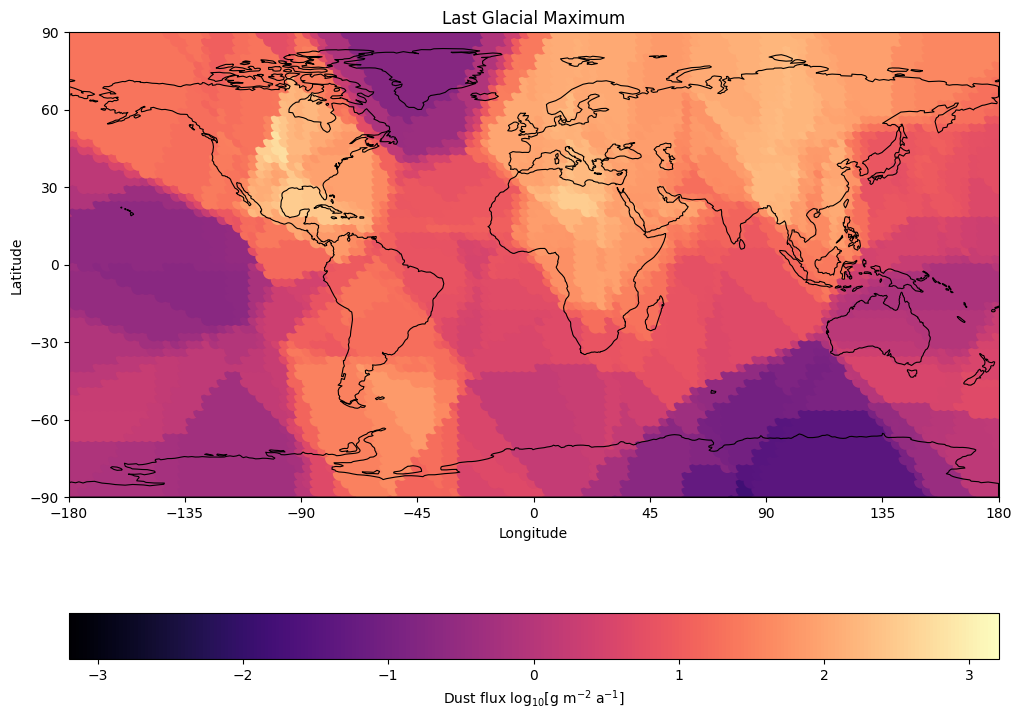

In [15]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [ ]:

estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():                                                                     
    point_for_estimation = (row["lon"], row["lat"])                                              
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

In [ ]:
est_geodesic_hol = df_global_grid["est_hol"].copy()  #Guardar valores y que no sean sobreescritos 
est_geodesic_lgm = df_global_grid["est_lgm"].copy()

In [ ]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [21]:
df_global_grid["dif_est_hol"] = np.abs(est_euclidian_hol - est_geodesic_hol) #Pregunte a gpt mejor opci√≥n si con absolute value o no
df_global_grid["dif_est_lgm"] = np.abs(est_euclidian_lgm - est_geodesic_hol)

In [22]:
df_global_grid_dif = df_global_grid.drop(columns=['est_hol', 'est_lgm']) #Chat gpt para .drop

In [28]:
df_analisis_grid = pd.concat([est_euclidian_hol, est_geodesic_hol,df_global_grid["dif_est_hol"], est_euclidian_lgm, est_geodesic_lgm, df_global_grid["dif_est_lgm"]], axis = 1)
print(df_analisis_grid)
df_analisis_grid.describe()

       est_hol   est_hol  dif_est_hol   est_lgm   est_lgm  dif_est_lgm
0    -0.736623 -3.034526     2.297903 -0.111441 -1.804872     2.923085
1    -0.736623 -3.034526     2.297903 -0.111441 -1.804872     2.923085
2    -0.736623 -3.034526     2.297903 -0.175193 -1.804872     2.859333
3    -0.736623 -3.034526     2.297903 -0.175193 -1.804872     2.859333
4    -0.740268 -3.034526     2.294258 -0.175193 -1.804872     2.859333
...        ...       ...          ...       ...       ...          ...
7376  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7377  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7378  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7379  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901
7380  0.388114 -0.889438     1.277551  1.583464 -0.272050     2.472901

[7381 rows x 6 columns]


est_hol      est_hol  dif_est_hol      est_lgm      est_lgm  \
count  7381.000000  7381.000000  7381.000000  7381.000000  7381.000000   
mean      0.014575    -0.295567     0.405867     0.736400     0.410496   
std       1.044539     1.205997     0.672228     0.989173     1.230231   
min      -2.730721    -3.107162     0.000000    -1.834825    -1.937201   
25%      -0.716035    -0.889438     0.000000    -0.026745    -0.509371   
50%       0.174538    -0.166646     0.049196     0.829739     0.614881   
75%       0.642920     0.523679     0.517005     1.522036     1.391107   
max       2.022372     2.006798     3.958761     2.815395     2.755189   

       dif_est_lgm  
count  7381.000000  
mean      1.073777  
std       0.883988  
min       0.000124  
25%       0.352262  
50%       0.836326  
75%       1.614331  
max       4.556562

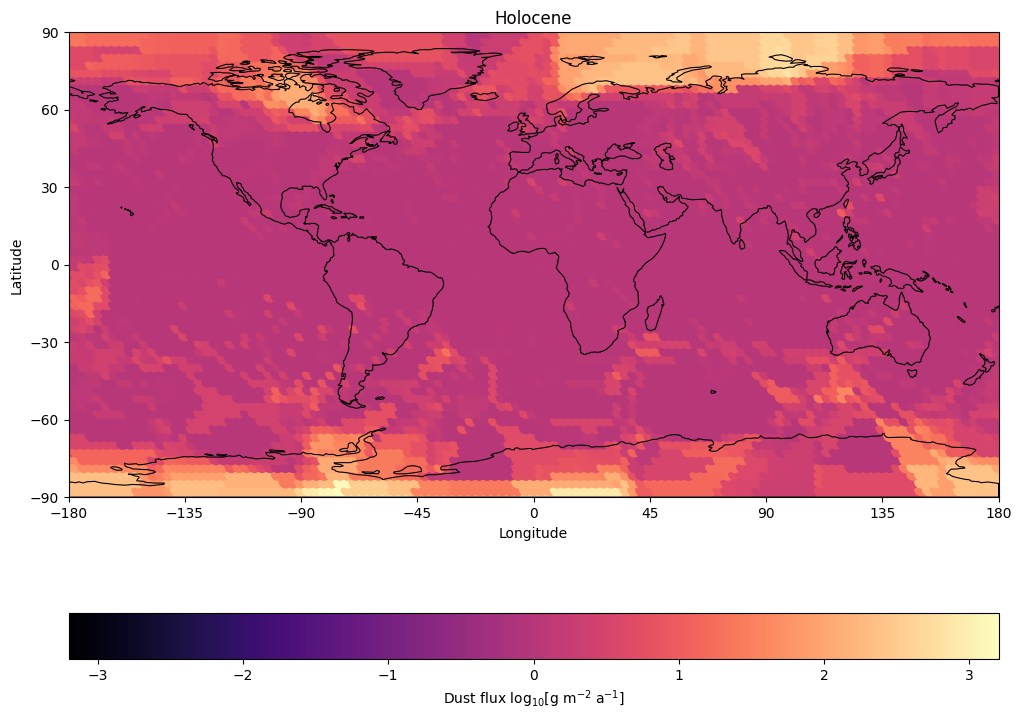

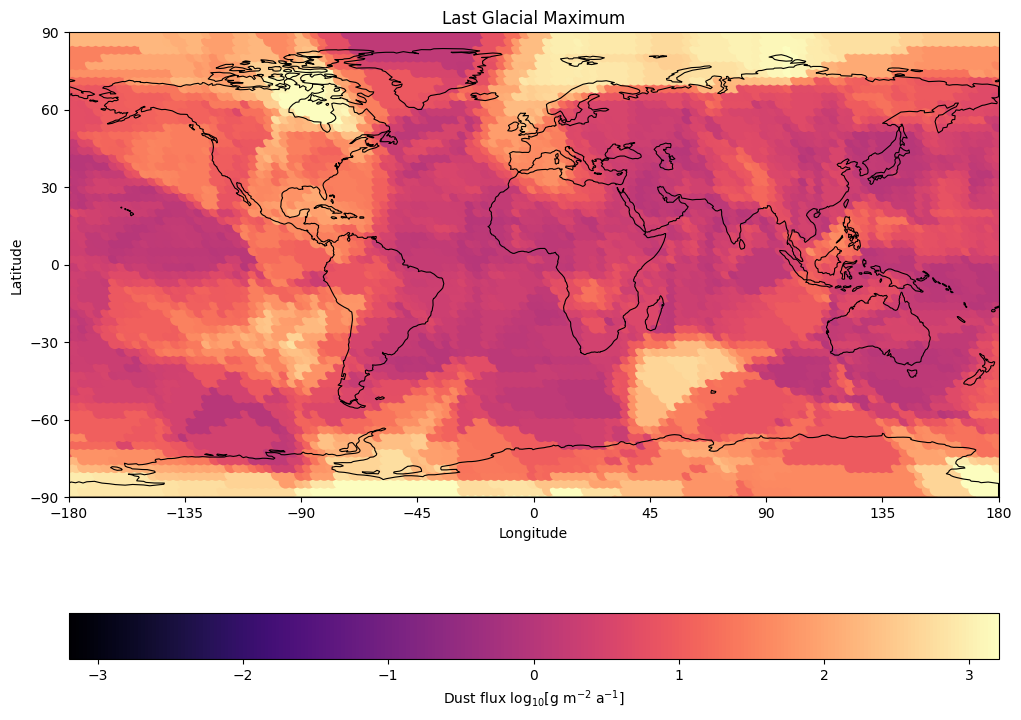

In [25]:
plot_dust_deposition_map(df=df_global_grid_dif,
                         title='Holocene',
                         name_to_save='DIFERENCE_ESTIMATION_MAP_HOLOCENE',
                         label_str='dif_est_hol')

plot_dust_deposition_map(df=df_global_grid_dif,
                         title='Last Glacial Maximum',
                         name_to_save='DIFERENCE_ESTIMATION_MAP_LGM',
                         label_str='dif_est_lgm')

### ¬øPor qu√© las diferencias son m√°s grandes en una parte que otra parte del mundo?
Las diferencias pueden deberse primero a los datos utilizados y la densidad/cantidad de estos por cada regi√≥n, esto cambiar√≠a bastante que tanta distancia hay entre un puntos, y tambi√©n que tan cerca se pueden encontrar los vecinos. Ya que la falta de registros modificar√≠a la existencia real de ciertos vecinos o cercanias entre lugares. 
Por otro lado, tambi√©n pueden haber diferencias por las caracter√≠sticas geogr√°ficas de estas partes del mundo en particular, seguramente hay variaci√≥n en los datos considerando si hay lugares que tengan mayor flujo por ser desiertos, tener corrientes marinas y otros. En la √∫ltima Era Glacial parece haberse acrecentado la diferencia en el continente americano, seguramente en conexi√≥n con el cambio clim√°tico o por la razones antes mencionadas. 
Tambi√©n debe considerarse que hay una notable diferencia en las √°reas de los polos en ambos mapas, esto podr√≠a suceder por la forma en que se contruye el modelo de divisi√≥n de latitud y longitud, considerando que en los polos convergen los meridianos, se ven afectadas las medidas de las coordenadas y por ende la distancia geod√©sica (que considera el componente es esferidad) 

### ¬øCu√°l m√©todo es m√°s fidedigno para los polos?
Considerando que en los polos convergen los meridianos y camb√≠a la concepci√≥n de longitud que hay porque las distancias se distorcionan respecto a territorios m√°s hacia el centro del globo, es que utilizar√≠a la distancia geod√©sica por la relevancia que tiene la curvatura en generar los cambios en las distancias. Considerando que comparativamente no se comportar√≠an igual que en lugares donde las latitudes y longitudes tiene la definici√≥n gradial m√°s uniforme en terminos de la divisi√≥n de la tierra. Todo esto considerando que las mediciones se hacen un plano de unidades longitud y latitud.   

Adem√°s en la era del holoceno la mayor diferencia se nota en los polos y en la era glacial tambi√©n ocurre lo mismo en algunas zonas polares, se identifica porque tiene el color m√°s claro. Lo que indicar√≠a alta diferencia en las estimaci√≥nes hechas por diferentes distancias, que podr√≠a deberse (no hay una causa asegurada) a la distorci√≥n en los polos. Si se ve particularmente en los mapas, los de la distnacia eucliana tienen muy poca marcaci√≥n de flujo respecto de los que muestra la distancia geod√©sica.

### ¬øCu√°l m√©todo es m√°s fidedigno en longitud 180¬∞ 
Tambi√©n se recomendar√≠a el uso de la distancia geod√©sica, considerando que si bien no existe la distorici√≥n por la convergencia de los meridianos a√∫n as√≠ se realizan los c√°lculos sobre una figura que no es originalmente plana sino que geoide/esf√©rica, por ende los m√°rgenes de error al usar la distancia euclidiana podr√≠an ser mayores, ya que la medici√≥n de latitud y longitus considera la figura de la tierra a diferencia de c√°lculos en planos 2d comunes. Pero a√∫n as√≠ se mira la divisi√≥n lat-long en sistema de plano, por lo que ambas distancias tienen alteraci√≥n. 

Aterrizando lo anterior a lo mostrado por el mapa de la diferencia de estimaciones, se puede notar que en el holoceno no hay mayor variaci√≥n en las estimaciones (hay un color morado cercano a los valores centro/0) por lo que usar una u otra distancia no parecer√≠a generar demaciado cambio si se trata solo de coordenadas en la longitud 180¬∞ y no en los polos. Sin embargo en la √∫ltima era glacial ya comienzan a haber una mayor diferencia en la estimaci√≥n dentro de la longitud 180¬∞, sobretodo en la parte del continente americano. Por lo que, se recomendar√≠a la distancia geod√©sica para descartar que hayan problemas con la distorci√≥n de valores producto de la cualidad esf√©rica de la tierra. 

### ¬øCu√°l son las diferencias entre el Holoceno y la √∫ltima era glacial ?

Si analizamos el mapa de la diferencia de estimaciones, se puede notar que del Holoceno a la √∫ltima era glacial las partes en la longitud 180¬∞ (no polos) dejaron de ser zonas tan bajas en flujo de polvo y comenzaron a existir ciertas zonas en algunos continentes con alta variaci√≥n en flujo; como ocurri√≥ con partes de cercanas al oeste de america del sur, zonas cercanas al sur de √Åfrica y tambi√©n en Am√©rica del norte. 


Si vemos individualmente los mapas de las distancias, se nota lo siguiente; 
1. Mapas distancia Geod√©sica:
   1. El flujo en el polo sur del holoceno respecto al de LGM dej√≥ de ser tan oscura (valores negativos) y lo mismo sucede con las zonas m√°s cercanas a los polos en Am√©rica del norte, la zona del oc√©ano pac√≠fico que est√° al oeste de Am√©rica del sur y partes cercanas al sur de Africa en el oc√©ano √çndico
   2. En practicamente todos continentes en la √∫ltima Era Glacial comienzan a haber en gran parte de su superficie un alza en el flujo de polvo, los colores comeinzan a ser mucho m√°s claro indicando un aumento.
   3. En general en la parte del oceano tambi√©n en la √∫ltima Era Glacial en su mayor√≠a hay colores mucho m√°s claros que indican un aumento en el flujo de polvo.

2. Mapas distancia euclidiana:
   1. En la √∫ltima era glacial en la superficie de los contienentes hay un aumento en el flujo de polvo, sobretodo en algunas partes cercanas al sur de Africa y America del norte.
   2. Las regiones que ten√≠an en el Holoceno un color muy oscuro (flujo negativo de polvo), siendo estas lo que en su mayor√≠a es Groelandia y la Ant√°rtica m√°s al este, en la √∫ltima era Glacial toman un color mucho m√°s claro, mostrando un valor positivo en el flujo de polvo

### ¬øC√≥mo elegir el n√∫mero de vecinos cercanos?
La elecci√≥n debe guiarse princialmente por el objetivo que se quiere lograr con el clustering pero tambi√©n por la cantidad de datos, considerando que una mayor cantidad de datos implica que la revisi√≥n es mucho m√°s extensa y la compactaci√≥n de los clusters se hace podr√≠a hacer mucho m√°s compleja. 
Por otro lado, se podr√≠a tener en cuenta de si aumentar o no el n√∫mero de vecinos cercanos permite disminuir la diferencia entre estimaciones con distintas distancias, pero deber√≠a analizarse si realmente existe un resultado que muestre algo as√≠.

Un m√©todo que permite elegir un n√∫mero de forma m√°s objetiva es la t√©cnica de la validaci√≥n cruzada, este permite dividir y trabajar los datos en m√∫liples escenarios evaluando con par√°metros matem√°ticos el rendimiento en distintos K que se seleccionen. 

Si bien existen t√©cnicas no "arbitrarias" de selecci√≥n de vecinos tambi√©n se puede considerar una elecci√≥n seg√∫n el contexto, viendo en la exploraci√≥n de datos los outliers si es que afectan demasiado a la selecci√≥n, el total de datos existentes y si una divisi√≥n en cierta cantidad de vecinos es lo √≥ptimo para el an√°lisis proporcionalmente hablando, entre otras cosas. 

#### Utilizaci√≥n de chat gpt:
Lo √∫tilic√© para entender:
1. C√≥mo funcionaba la b√∫squeda de vecinos cercanos y c√≥mo variaba seg√∫n los argumentos que se mov√≠an (distancia)
2. C√≥mo funcionan los meridianos y las longitudes/latitudes en los polos respecto al resto de la esfera 
3. C√≥mo podr√≠a influir la distancia euclidiana en partes m√°s centro del plano (variaci√≥n num√©rica)
4. Chequeo doble de la form√∫la que constru√≠ de distancia euclidiana (no realiz√≥ ning√∫n cambio original a la f√≥rmula, yo la segu√≠ directamente del enunciado) 
5. Comandos de numpy y diferencias entre merge/concat 
6. Significado de la barra de valores de flujo de polvo en los gr√°ficos 
7. En base a qu√© figura se construy√≥ la distancia geod√©sica y la euclidiana
8. Informaci√≥n y contexto sobre la √∫ltima era glacial y el holoceno, para asociar los cambios en los mapas
9. Comando en math para transformaci√≥n a radianes
10. Aumento del k y valores matem√°ticos afectados, pasos de la validaci√≥n cruzada y contexto